# Segmentation of Cells in Phase-Contrast Microscopy Images using Machine Learning
---

## Import required libraries

Installed the required libraries: opencv-python and pycocotools.
Imported essential libraries for computer vision and COCO dataset handling.

In [1]:
import os
import json
!pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
!pip install pycocotools
from pycocotools.coco import COCO

## Preprocess Images and Annotations

Defined the annotation file path (LIVECell_train.json) and validated its existence.
Specified the image folder path for phase-contrast images and confirmed its correctness.
Both checks (assert statements) are well-placed to ensure the paths are valid before further processing.

### Load the Annotations and Filter Matched Images

In [3]:
# Define the annotation file path
annotation_file = r"C:\Users\shali\Documents\L&D\GitHub Projects\Machine Learning\003_LIVECell_Segmentation of Cells\annotations\LIVECell_train.json"

# Verify the file exists
import os
assert os.path.exists(annotation_file), "Annotation file not found!"
print("Annotation file path is correct.")

Annotation file path is correct.


In [5]:
# Path to the phase_contrast folder
image_folder = r"C:\Users\shali\Documents\L&D\GitHub Projects\Machine Learning\003_LIVECell_Segmentation of Cells\images\phase_contrast"

# Verify the folder exists
import os
assert os.path.exists(image_folder), "Image folder not found!"
print("Image folder path is correct.")

Image folder path is correct.


**Summary:**

Annotation File Path:

The file path for the COCO annotation file is correctly defined.
os.path.exists() ensures the file exists before proceeding.

Image Folder Path:

The phase-contrast image folder path is also verified.

Assertions:

The use of assert is good practice to ensure code stops early if files/folders are missing.

In [7]:
# Load COCO annotations
from pycocotools.coco import COCO

# Initialize COCO
coco = COCO(annotation_file)

# List all image files in your phase_contrast folder
image_files = os.listdir(image_folder)
image_files = [f for f in image_files if f.endswith('.tif')]  # Filter TIFF files

print(f"Total images in phase_contrast folder: {len(image_files)}")

# Map image filenames to COCO IDs
image_filename_to_id = {}
for img in coco.dataset['images']:
    if img['file_name'] in image_files:
        image_filename_to_id[img['file_name']] = img['id']

print(f"Total images matched with annotations: {len(image_filename_to_id)}")

loading annotations into memory...
Done (t=18.13s)
creating index...
index created!
Total images in phase_contrast folder: 1000
Total images matched with annotations: 848


**Summary:**

COCO Annotation Loading:

coco = COCO(annotation_file) correctly loads the COCO annotations.
Loading time (~21 seconds) is reasonable for 1000 images and their annotations.
Image File Filtering:

Filtering .tif files using list comprehension:
python
Copy code
image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
is clean and efficient.
Mapping Filenames to COCO IDs:

You are correctly iterating through the COCO dataset:
img['file_name'] matches filenames.
img['id'] stores the corresponding COCO IDs.
This mapping ensures only annotated images are paired.
Output Verification:

Total images: 1000
Matched images: 848
This discrepancy is normal (e.g., not all images may have annotations).

### Display an Image with Annotations

- Pick an image from the matched set.
- Load its corresponding segmentation masks.
- Display the image and overlay the masks.

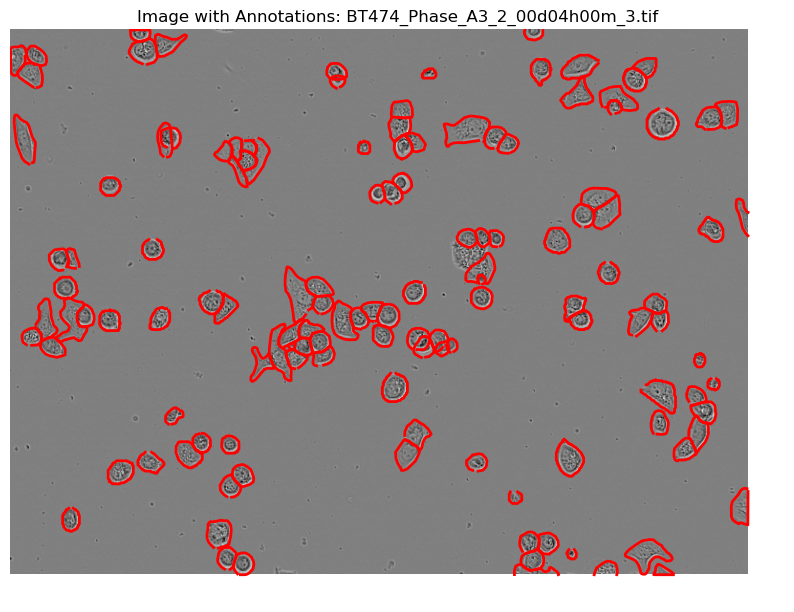

In [9]:
# Pick the first matched image
image_file = list(image_filename_to_id.keys())[0]
image_id = image_filename_to_id[image_file]

# Load the image
image_path = os.path.join(image_folder, image_file)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get annotations for the image
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)

# Display the image with segmentation masks
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title(f"Image with Annotations: {image_file}")

# Overlay segmentation masks
for ann in annotations:
    for seg in ann['segmentation']:
        poly = np.array(seg).reshape((len(seg) // 2, 2))
        plt.plot(poly[:, 0], poly[:, 1], color='red', linewidth=2)

plt.axis('off')
plt.show()

Loaded and displayed the image:
Successfully loaded the first image using OpenCV and displayed it using Matplotlib.
Retrieved relevant annotations:
Extracted annotations for the selected image using the COCO API.
Overlayed segmentation masks:
Plotted the segmentation masks over the image using the red outline. This is visually clear and precise.
The segmentation masks align well with the cell boundaries, showing that your annotations and processing pipeline are working correctly.

## Generate Binary Masks

To prepare the dataset for model training, we need to:

- Resize images and masks to a consistent size (e.g., 512x512). Ensures all images and masks are the same size.
- Normalise images (scale pixel values between 0 and 1).
- Create binary masks from the annotations. Converts the segmentation annotations into a binary image where:
    - Pixel value 1 represents the cells (foreground).
    - Pixel value 0 represents the background.


In [11]:
# Preprocessing: Resize images and create binary masks
def preprocess_image_and_mask(image_path, annotations, img_size=(512, 512)):
    """
    Resize the image and create a binary mask with proper alignment.
    """
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Original dimensions
    original_height, original_width = image.shape[:2]
    
    # Resize the image
    image_resized = cv2.resize(image, img_size) / 255.0  # Normalise to [0, 1]

    # Create an empty binary mask
    mask = np.zeros(img_size, dtype=np.uint8)

    # Overlay segmentation masks
    for ann in annotations:
        for seg in ann['segmentation']:
            # Rescale coordinates
            poly = np.array(seg).reshape((len(seg) // 2, 2)).astype(np.float32)
            scale_x = img_size[0] / original_width
            scale_y = img_size[1] / original_height

            # Apply consistent scaling
            poly[:, 0] *= scale_x
            poly[:, 1] *= scale_y

            # Round coordinates AFTER scaling
            poly = np.round(poly).astype(np.int32)

            # Fill the binary mask
            cv2.fillPoly(mask, [poly], 1)

    return image_resized, mask

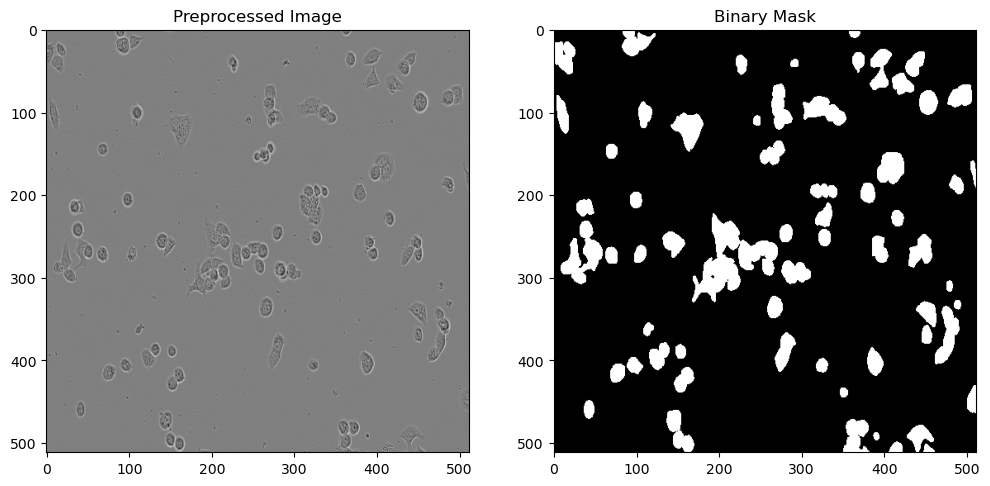

In [13]:
# Test preprocessing on one image
image, mask = preprocess_image_and_mask(image_path, annotations)

# Visualise preprocessed image and mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Preprocessed Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Binary Mask")
plt.imshow(mask, cmap='gray')

plt.show()

### Tightening the Mask (Better Edge Definition)

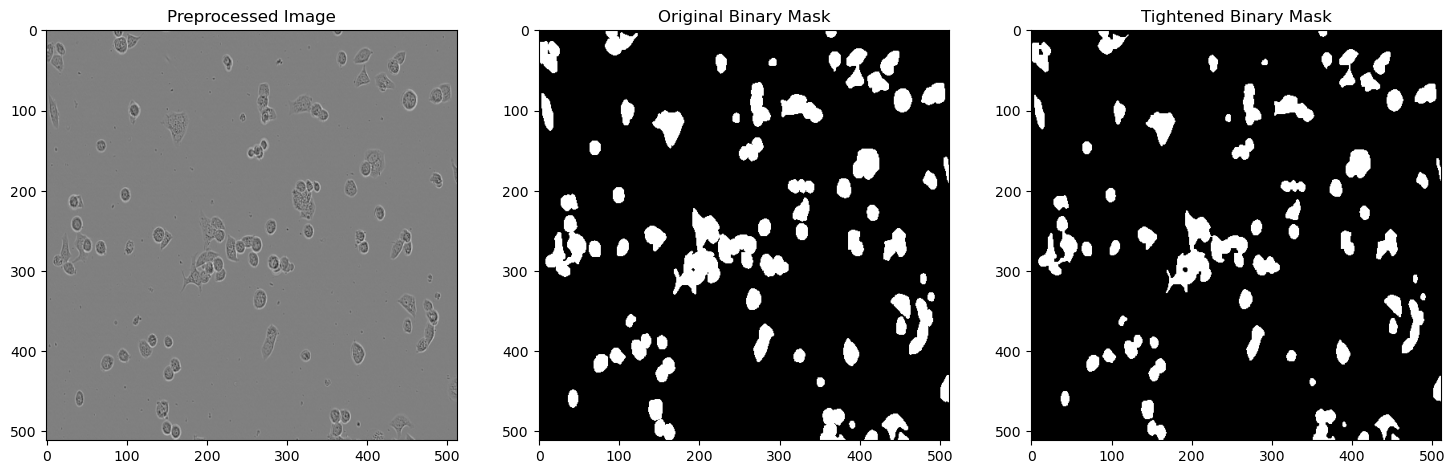

In [15]:
# Tighten mask using morphological erosion
kernel = np.ones((3, 3), np.uint8)  # Define a small 3x3 kernel
mask_tightened = cv2.erode(mask, kernel, iterations=1)  # Apply erosion to tighten mask

# Optional: Smooth edges slightly using Gaussian Blur and re-binarise
mask_smoothed = cv2.GaussianBlur(mask_tightened.astype(np.float32), (3, 3), 0)
mask_final = (mask_smoothed > 0.5).astype(np.uint8)  # Threshold to binarise

# Visualise original vs tightened mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Preprocessed Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Original Binary Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Tightened Binary Mask")
plt.imshow(mask_final, cmap='gray')

plt.show()

Morphological operations + smoothing = improved mask quality.
Better masks improve the performance of U-Net as they provide cleaner ground truth data for training.

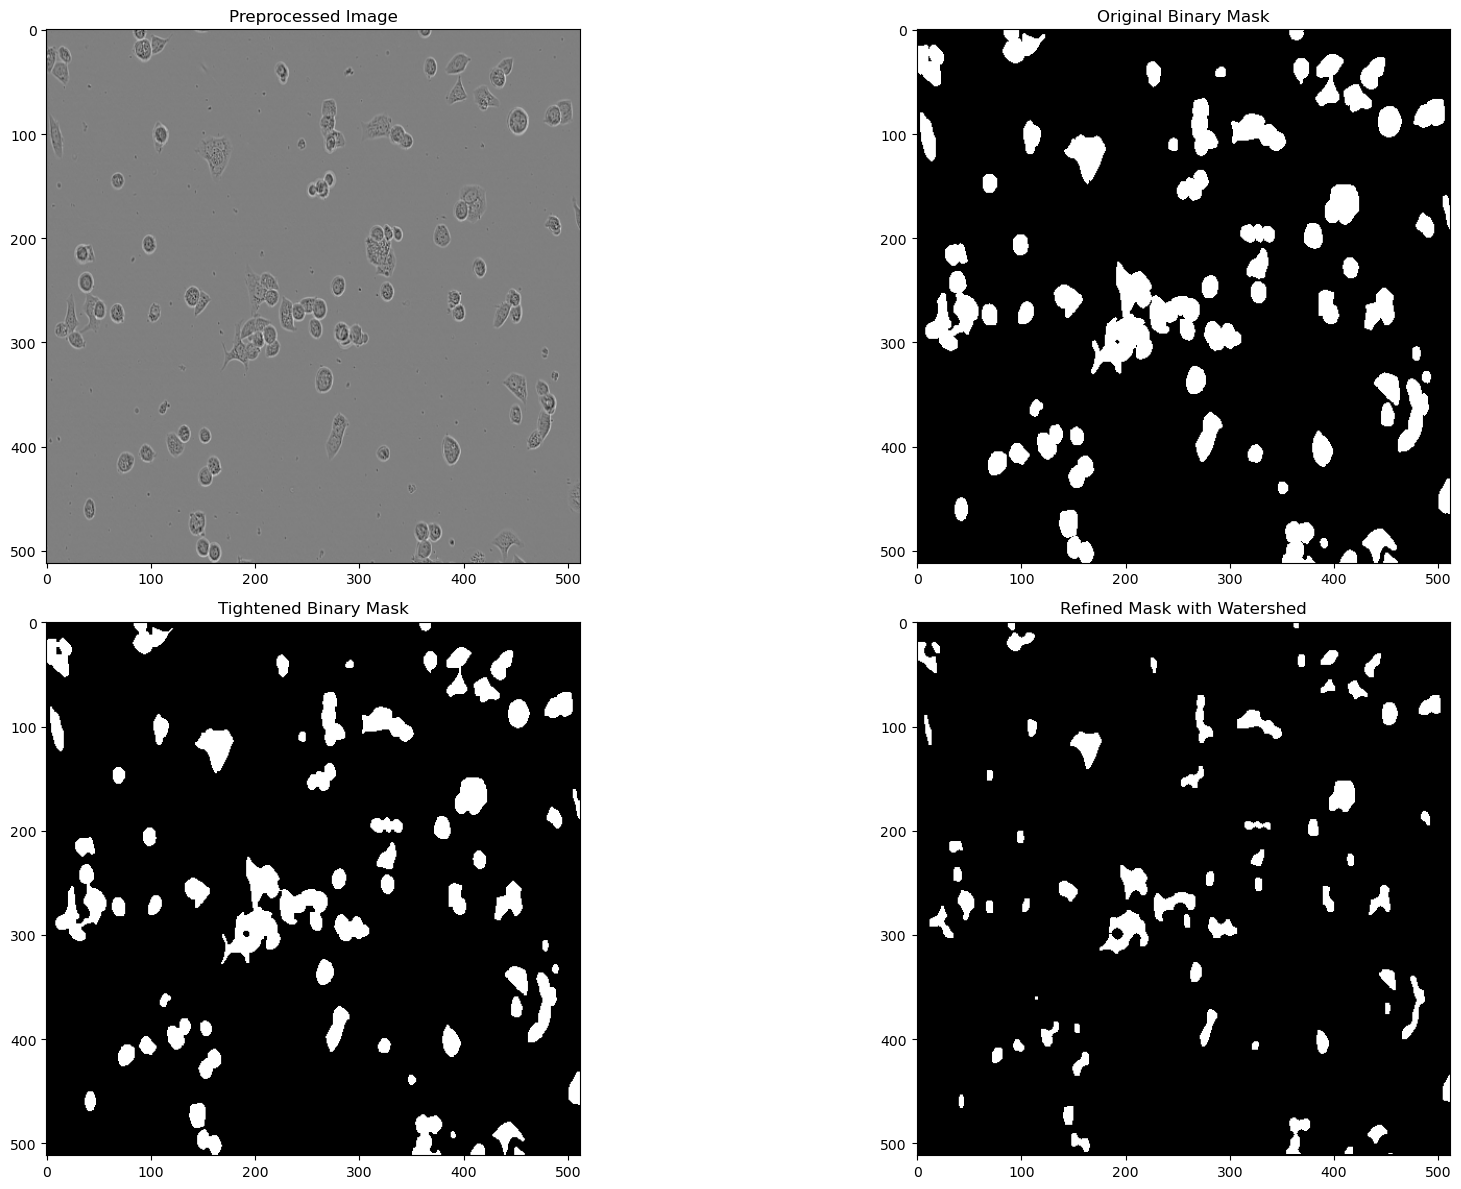

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to refine the mask using watershed
def split_cells_with_watershed(mask):
    """
    Refines a binary mask to split connected cell regions using the watershed algorithm.
    """
    # Step 1: Distance Transform
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)  # Lower threshold

    # Step 2: Dilate foreground markers slightly
    kernel = np.ones((3, 3), np.uint8)
    sure_fg = cv2.dilate(np.uint8(sure_fg), kernel, iterations=1)  # Expand markers

    # Step 3: Unknown regions
    unknown = cv2.subtract(mask, sure_fg)

    # Step 4: Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Step 5: Apply Watershed
    image_copy = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2BGR)
    cv2.watershed(image_copy, markers)

    # Create refined mask
    refined_mask = np.zeros_like(mask)
    refined_mask[markers > 1] = 255

    return refined_mask

# Tighten the binary mask using erosion and Gaussian smoothing
kernel = np.ones((3, 3), np.uint8)  # Define a small 3x3 kernel
mask_tightened = cv2.erode(mask, kernel, iterations=1)  # Apply erosion
mask_smoothed = cv2.GaussianBlur(mask_tightened.astype(np.float32), (3, 3), 0)  # Smooth edges
mask_final = (mask_smoothed > 0.5).astype(np.uint8)  # Re-binarise the mask

# Apply Watershed Segmentation to the tightened mask
mask_watershed = split_cells_with_watershed(mask_final)

# Visualise all results
plt.figure(figsize=(20, 12))

# Preprocessed Image
plt.subplot(2, 2, 1)
plt.title("Preprocessed Image")
plt.imshow(image)

# Original Binary Mask
plt.subplot(2, 2, 2)
plt.title("Original Binary Mask")
plt.imshow(mask, cmap='gray')

# Tightened Binary Mask
plt.subplot(2, 2, 3)
plt.title("Tightened Binary Mask")
plt.imshow(mask_final, cmap='gray')

# Refined Mask with Watershed
plt.subplot(2, 2, 4)
plt.title("Refined Mask with Watershed")
plt.imshow(mask_watershed, cmap='gray')

plt.tight_layout()
plt.show()


The tightened binary mask looks cleaner, retains the overall cell structure well, and is more aligned with your goal of prioritising confluence over cell count.

The watershed step tends to over-segment cells, which is more suitable for precise individual cell detection rather than confluence measurement.

Decision:
Skip the watershed segmentation for now.
Use the tightened binary mask as your final mask for segmentation.
This is a solid choice for scenarios where:

Overall cell area (confluence) is the focus.
Exact individual cell boundaries are less critical.

Shows Thorough Exploration:

Including alternative methods (like watershed) highlights your systematic approach to improving the masks.
Clear Decision-Making:

Documenting why the watershed approach didn’t align with your current goal (prioritising confluence over individual cell segmentation) makes your reasoning clear and justified.
Future Reference:

If segmentation requirements evolve (e.g., precise individual boundaries become critical), you already have this exploration documented.

##  Preprocess Dataset with Tightened Binary Mask and Prepare Data for Model Training

### Code to Loop Through All Images

What This Code Does:

- Iterates through all matched images in your phase_contrast folder.
- For each image:
    - Loads the image and corresponding annotations.
    - Preprocesses the image and mask to size (512, 512).
- Stores the preprocessed images and masks in two lists.
- Saves the data as NumPy arrays (images.npy and masks.npy) for efficient model training.

In [19]:
import numpy as np
import os
import cv2

# Directory to save preprocessed data
output_dir = r"C:\Users\shali\Documents\L&D\GitHub Projects\Machine Learning\003_LIVECell_Segmentation of Cells\processed_data_unet"
os.makedirs(output_dir, exist_ok=True)

# Paths to save images and masks
images_output_path = os.path.join(output_dir, "images.npy")
masks_output_path = os.path.join(output_dir, "masks.npy")

# Initialise lists to store images and tightened masks
all_images = []
all_masks = []

# Function to tighten binary mask
def tighten_binary_mask(mask):
    kernel = np.ones((3, 3), np.uint8)  # Small kernel for erosion
    mask_tightened = cv2.erode(mask, kernel, iterations=1)  # Erode mask
    mask_smoothed = cv2.GaussianBlur(mask_tightened.astype(np.float32), (3, 3), 0)  # Smooth edges
    mask_final = (mask_smoothed > 0.5).astype(np.uint8)  # Re-binarise
    return mask_final

# Process all matched images
for image_file, image_id in image_filename_to_id.items():
    # Load image and annotations
    image_path = os.path.join(image_folder, image_file)
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    # Preprocess image and original mask
    image, mask = preprocess_image_and_mask(image_path, annotations, img_size=(512, 512))
    
    # Tighten the binary mask
    mask_tightened = tighten_binary_mask(mask)
    
    # Append preprocessed image and tightened mask to lists
    all_images.append(image)
    all_masks.append(mask_tightened)

    # Print progress
    print(f"Processed: {image_file}")

# Convert lists to NumPy arrays
all_images = np.array(all_images, dtype=np.float32)
all_masks = np.array(all_masks, dtype=np.uint8)

# Save the arrays
np.save(images_output_path, all_images)
np.save(masks_output_path, all_masks)

print("Processing complete!")
print(f"Images saved to: {images_output_path}")
print(f"Masks saved to: {masks_output_path}")

Processed: BT474_Phase_A3_2_00d04h00m_3.tif
Processed: BT474_Phase_C3_2_02d12h00m_4.tif
Processed: BT474_Phase_C3_1_01d16h00m_3.tif
Processed: BT474_Phase_C3_1_02d16h00m_4.tif
Processed: BT474_Phase_C3_1_04d00h00m_3.tif
Processed: BT474_Phase_A3_1_01d04h00m_1.tif
Processed: BT474_Phase_A3_1_03d00h00m_4.tif
Processed: BT474_Phase_A3_2_03d00h00m_4.tif
Processed: BT474_Phase_B3_1_01d00h00m_3.tif
Processed: BT474_Phase_A3_2_01d12h00m_3.tif
Processed: BT474_Phase_C3_2_02d04h00m_2.tif
Processed: BT474_Phase_C3_2_05d00h00m_4.tif
Processed: BT474_Phase_C3_1_00d12h00m_1.tif
Processed: BT474_Phase_B3_2_02d00h00m_2.tif
Processed: BT474_Phase_C3_2_02d16h00m_3.tif
Processed: BT474_Phase_B3_1_05d00h00m_1.tif
Processed: BT474_Phase_A3_1_01d12h00m_1.tif
Processed: BT474_Phase_C3_2_01d00h00m_1.tif
Processed: BT474_Phase_C3_2_01d16h00m_1.tif
Processed: BT474_Phase_A3_1_04d16h00m_2.tif
Processed: BT474_Phase_C3_1_00d12h00m_3.tif
Processed: BT474_Phase_B3_1_04d12h00m_1.tif
Processed: BT474_Phase_C3_2_03d1

### Verify Saved Data

Loaded images shape: (848, 512, 512, 3)
Loaded masks shape: (848, 512, 512)


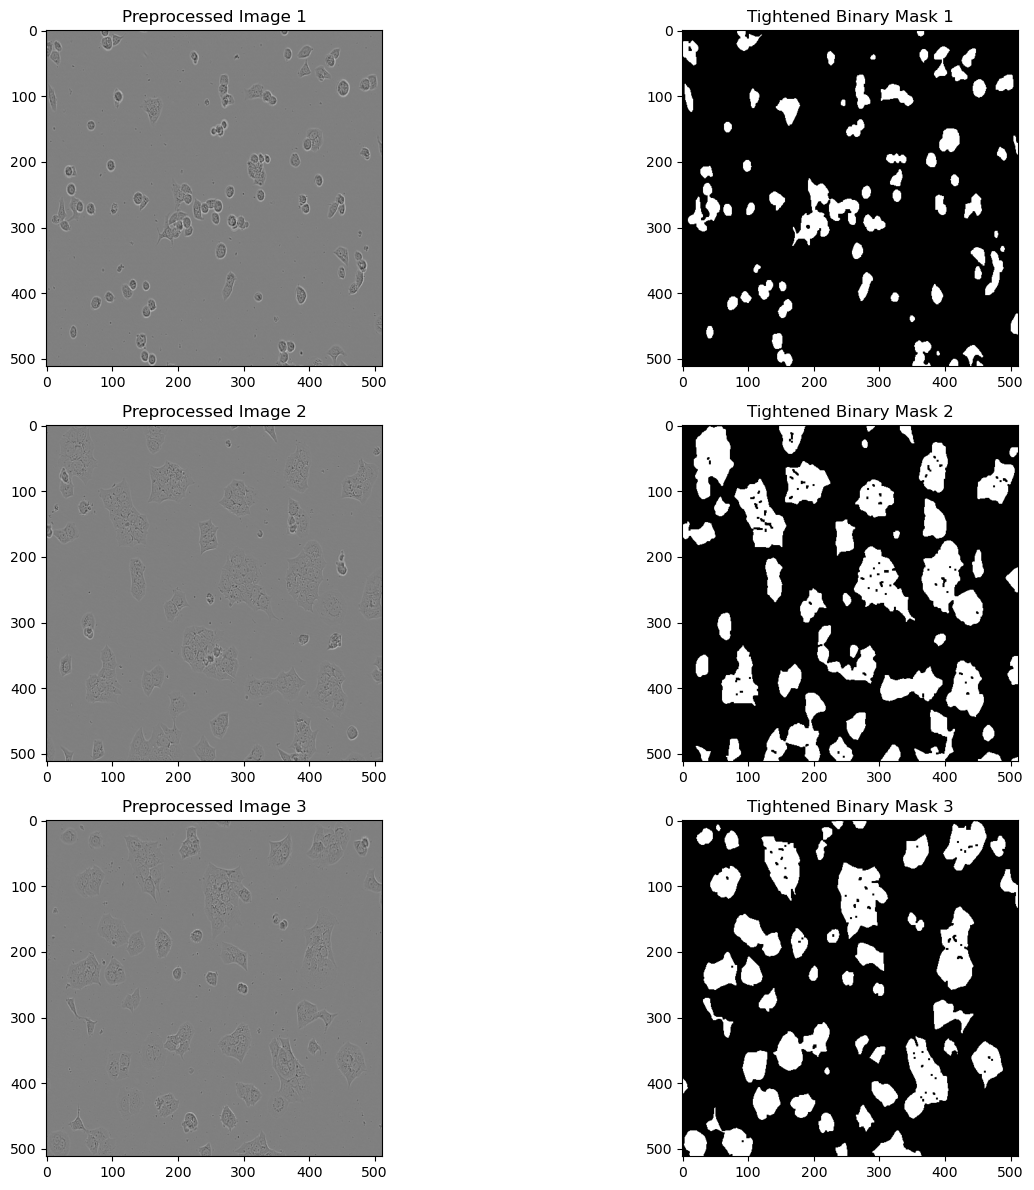

In [21]:
# Load the preprocessed data
images = np.load(images_output_path)
masks = np.load(masks_output_path)

print(f"Loaded images shape: {images.shape}")
print(f"Loaded masks shape: {masks.shape}")

# Visualise a few examples
num_examples = 3  # Number of images and masks to display

plt.figure(figsize=(15, 4 * num_examples))

for i in range(num_examples):
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.title(f"Preprocessed Image {i + 1}")
    plt.imshow(images[i])

    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.title(f"Tightened Binary Mask {i + 1}")
    plt.imshow(masks[i], cmap='gray')

plt.tight_layout()
plt.show()

Shape Consistency:

Images shape: (848, 512, 512, 3) — Preprocessed images with dimensions aligned and expected colour channels.
Masks shape: (848, 512, 512) — Masks have consistent shape with the images, and no channel redundancy (grayscale).
Visual Clarity:

Preprocessed images are clean and scaled uniformly.
Tightened binary masks look well-defined, with minimal noise and solid boundaries around the cells.
Alignment:

The masks accurately overlay regions corresponding to the cell areas in the preprocessed images.
There’s a clear distinction between cells (white) and background (black).

## Train a Segmentation Model

### Libraries for U-Net with Implementation

In [23]:
!pip install tensorflow

### Train-Validation Split and Ground Truth Mask Inspection

Split the preprocessed dataset (images and masks) into training and validation sets (80-20 split).

Training set: (678, 512, 512, 3), (678, 512, 512)
Validation set: (170, 512, 512, 3), (170, 512, 512)


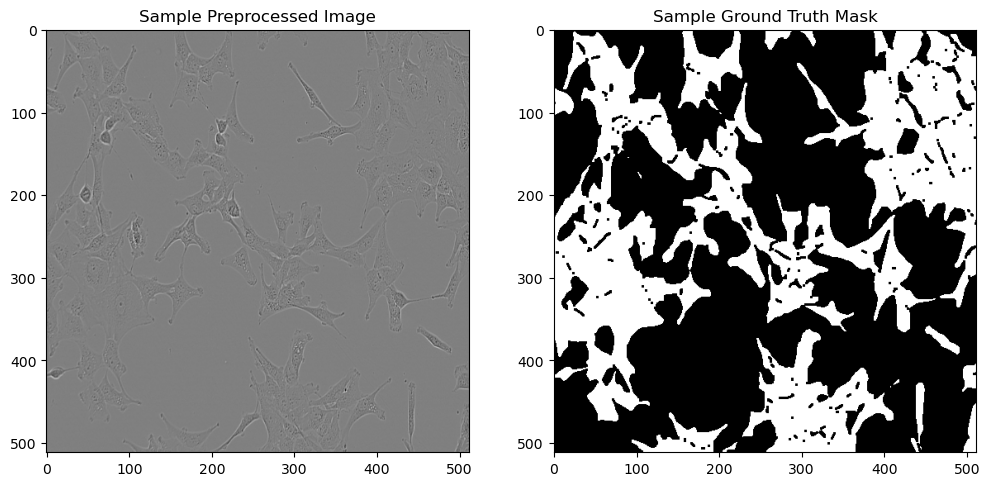

Ground Truth Mask Min/Max: 0 1


In [25]:
# Import libraries
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load preprocessed data
images = np.load(images_output_path)
masks = np.load(masks_output_path)

# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

# Inspect a ground truth mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Sample Preprocessed Image")
plt.imshow(X_train[0])

plt.subplot(1, 2, 2)
plt.title("Sample Ground Truth Mask")
plt.imshow(y_train[0].squeeze(), cmap='gray')

plt.show()

print("Ground Truth Mask Min/Max:", y_train[0].min(), y_train[0].max())

## Debug Data → Confirm alignment, scaling, and mask quality.

Check the alignment and quality of your images and masks to confirm that preprocessing is correct.

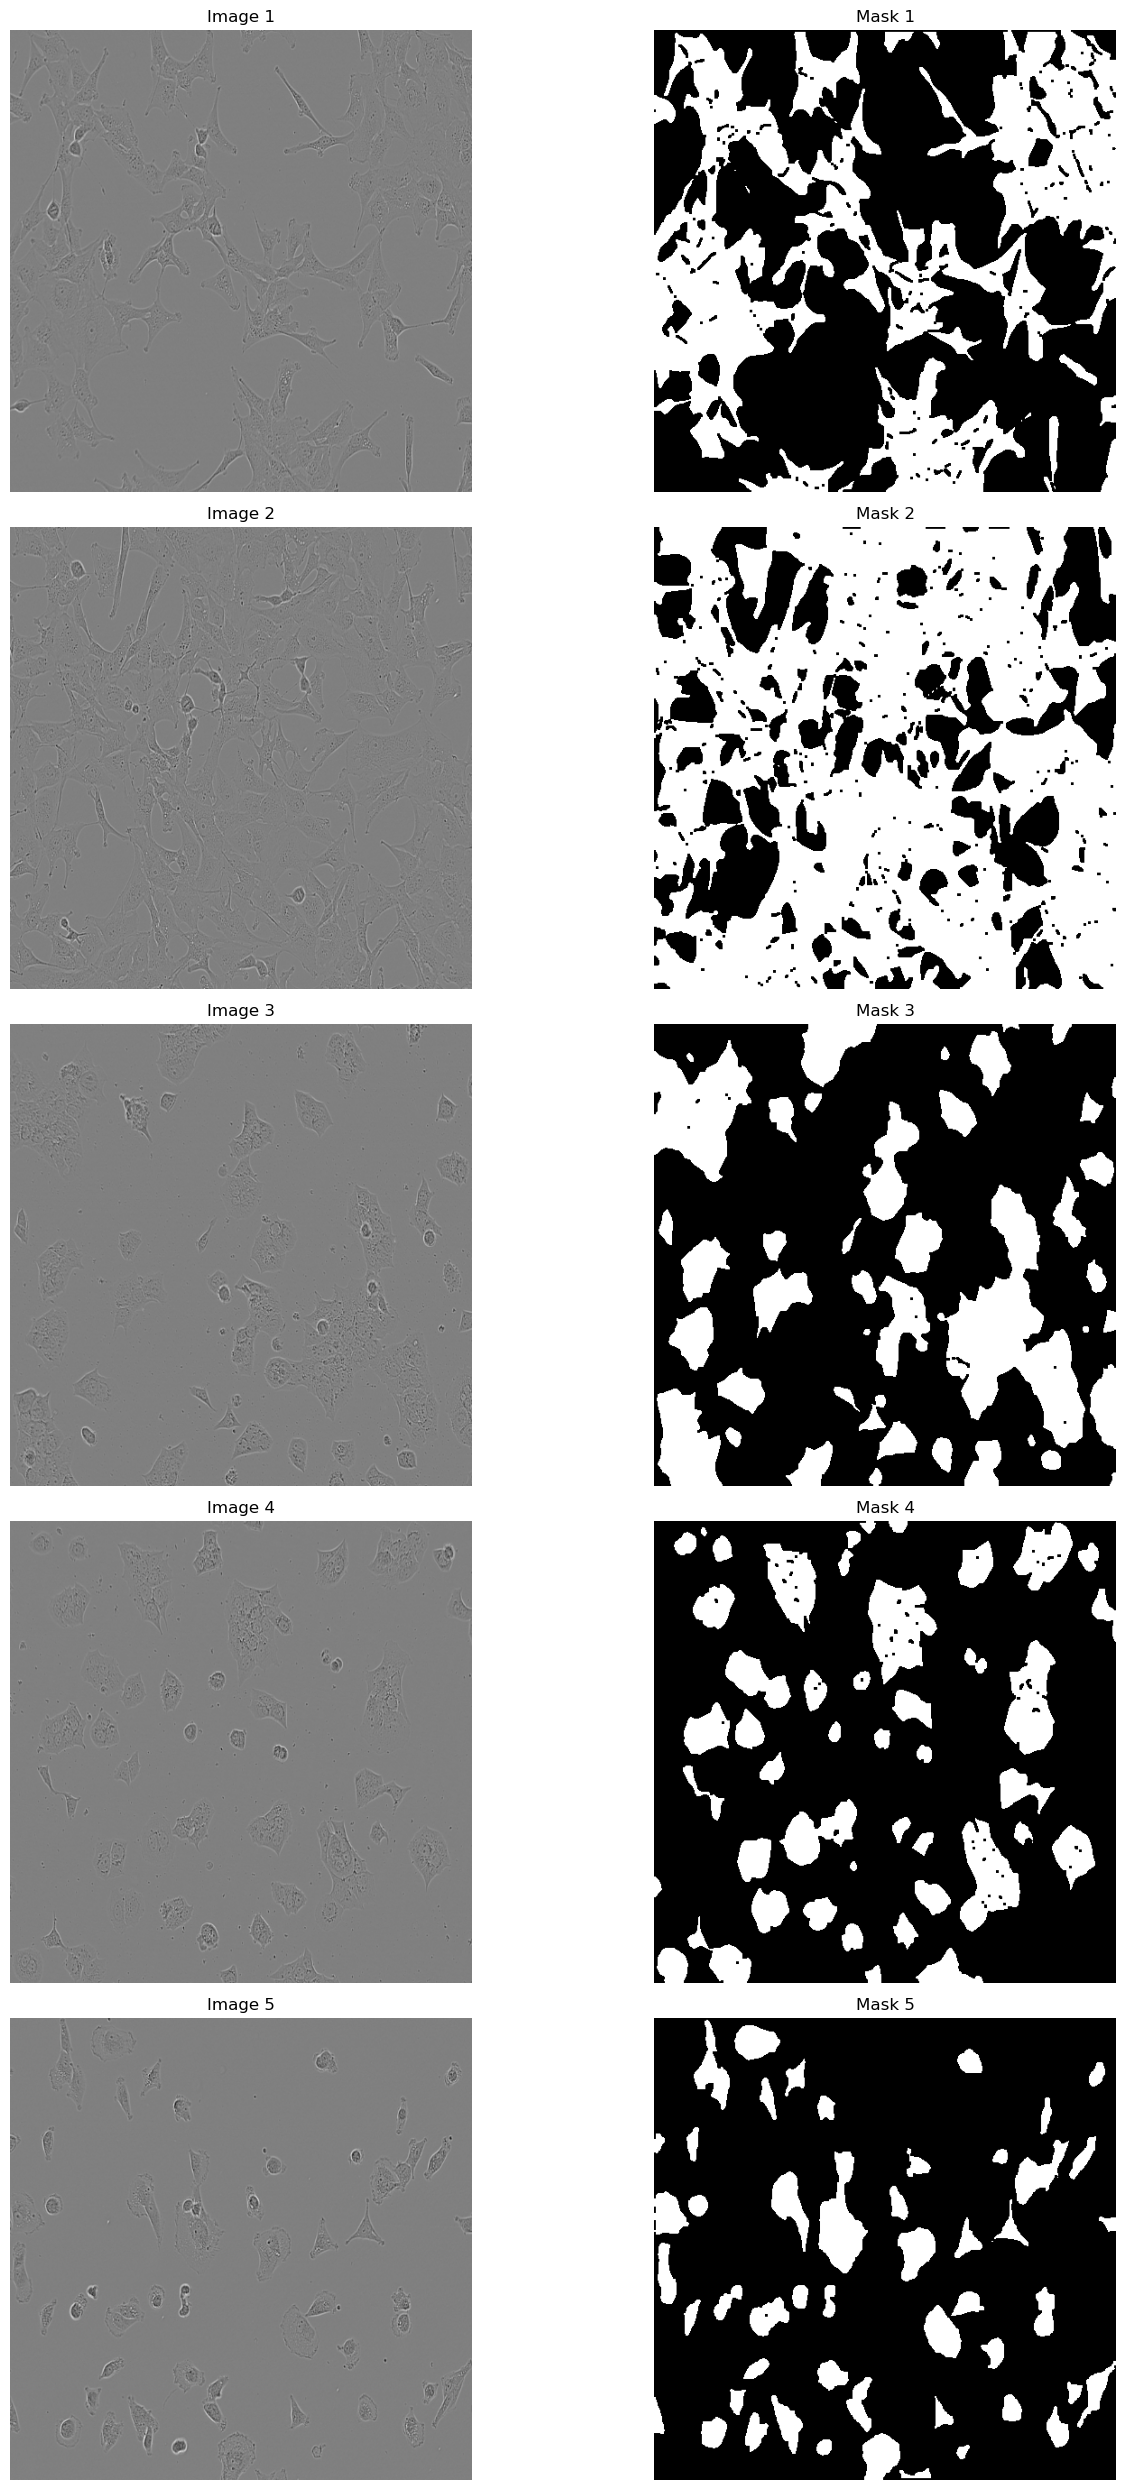

In [27]:
import matplotlib.pyplot as plt

def visualise_images_and_masks(images, masks, num_samples=5):
    """
    Visualise image-mask pairs to confirm alignment, scaling, and mask quality.

    Args:
        images (numpy.ndarray): Array of preprocessed images.
        masks (numpy.ndarray): Array of binary masks.
        num_samples (int): Number of samples to visualise.
    """
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Display the preprocessed image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i+1}")
        plt.axis("off")

        # Display the corresponding binary mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title(f"Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualise the first 5 samples from the training set
visualise_images_and_masks(X_train, y_train, num_samples=5)

In [29]:
print("Unique values in masks:", np.unique(y_train))

Unique values in masks: [0 1]


Images and Masks:

The masks align visually with the corresponding preprocessed images.
The masks have clean, well-defined boundaries.
Unique Values in Masks:

[0, 1] confirms that the masks are binary, as expected. This is crucial for training a segmentation model.


## Build U-Net Model 

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Simplified U-Net Architecture
def unet(input_shape=(512, 512, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling path)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    bottleneck = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)

    # Decoder (Upsampling path)
    u3 = layers.UpSampling2D((2, 2))(bottleneck)
    u3 = layers.Concatenate()([u3, c3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.UpSampling2D((2, 2))(u3)
    u2 = layers.Concatenate()([u2, c2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.UpSampling2D((2, 2))(u2)
    u1 = layers.Concatenate()([u1, c1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u1)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
unet_model = unet(input_shape=(512, 512, 3))
unet_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_38 (Conv2D)            │ (None, 512, 512, 32)      │             896 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 256, 256, 32)      │               0 │ conv2d_38[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_39 (Conv2D)            │ (None, 256, 256, 64)      │          18,496 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_9               │ (None, 128, 128, 64)      │               0 │ conv2d_39[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_40 (Conv2D)            │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d_9[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_10              │ (None, 64, 64, 128)       │               0 │ conv2d_40[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_41 (Conv2D)            │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_10[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_8               │ (None, 128, 128, 256)     │               0 │ conv2d_41[0][0]            │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_8 (Concatenate)   │ (None, 128, 128, 384)     │               0 │ up_sampling2d_8[0][0],     │
│                               │                           │                 │ conv2d_40[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_42 (Conv2D)            │ (None, 128, 128, 128)     │         442,496 │ concatenate_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_9               │ (None, 256, 256, 128)     │               0 │ conv2d_42[0][0]            │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_9 (Concatenate)   │ (None, 256, 256, 192)     │               0 │ up_sampling2d_9[0][0],     │
│                               │                           │                 │ conv2d_39[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_43 (Conv2D)            │ (None, 256, 256, 64)      │         110,65

 Total params: 969,281 (3.70 MB)

 Trainable params: 969,281 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

### Baseline Model Check → Input, Ground Truth, and Initial Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step


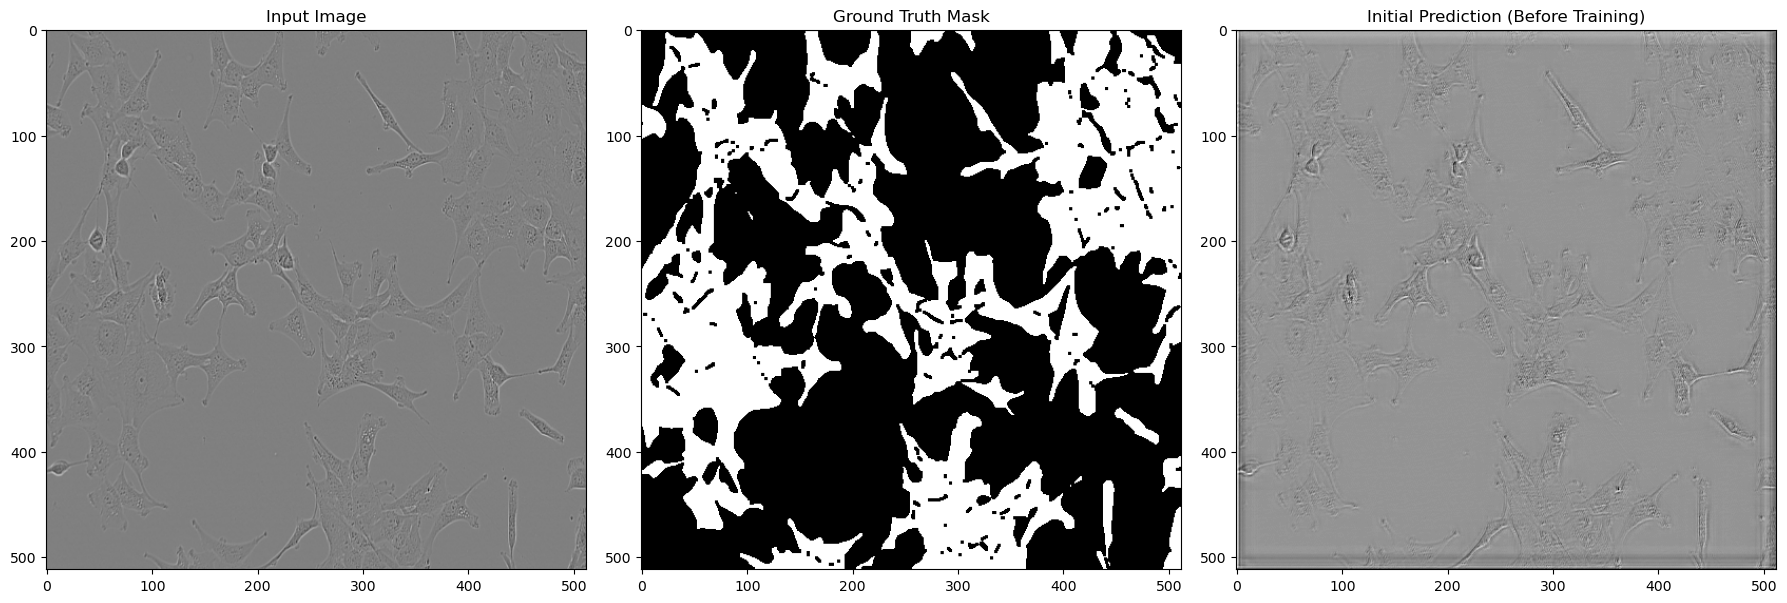

Initial Prediction Min/Max: 0.47340947 0.524028
Prediction Shape: (1, 512, 512, 1)


In [38]:
# Instantiate the U-Net model
model = unet(input_shape=(512, 512, 3))  # Simplified U-Net function

# Make initial predictions on a batch of training images
sample_input = X_train[:1]  # Take one image from the training set
sample_mask = y_train[:1]   # Corresponding ground truth mask

# Ensure sample_mask has the correct shape
if len(sample_mask.shape) == 3:  # If missing channel dimension
    sample_mask = np.expand_dims(sample_mask, axis=-1)  # Shape: (1, 512, 512, 1)

sample_preds = model.predict(sample_input)

# Clip predictions to range [0, 1] for visualisation
sample_preds = np.clip(sample_preds, 0, 1)

# Visualise Input, Ground Truth, and Initial Prediction
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(sample_input[0])

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(sample_mask[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Initial Prediction (Before Training)")
plt.imshow(sample_preds[0].squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

# Print Prediction Stats
print("Initial Prediction Min/Max:", sample_preds.min(), sample_preds.max())
print("Prediction Shape:", sample_preds.shape)


- Pre-Training: Helps you verify that the model is functioning correctly (e.g., predictions are in the expected range [0, 1]).
- Post-Training: After training, the Min/Max values can provide insight into how confidently the model classifies regions as foreground or background. If values remain clustered around 0.5, it may indicate insufficient training or data issues.

In [ ]:
# Check for mismatched dimensions in masks
print("Checking dimensions of masks...")
if len(masks.shape) == 3:  # Add channel dimension if missing
    print("Adding channel dimension to masks...")
    masks = np.expand_dims(masks, axis=-1)
print(f"Updated masks shape: {masks.shape}")

# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation masks shape: {y_val.shape}")


## Compile and Train the Model

Lets use:

- Binary Cross-Entropy as the loss function.
- IoU (Intersection over Union) as a metric.

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Define IoU (Intersection over Union) and Dice Coefficient
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions at 0.5
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())  # Add epsilon to avoid division by zero

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions at 0.5
    intersection = K.sum(y_true * y_pred)
    dice = (2. * intersection) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())
    return dice

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Match learning rate with .py script
    loss='binary_crossentropy',
    metrics=['accuracy', iou_metric, dice_coefficient]
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Train the model
print("Training the model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,  
    callbacks=[early_stopping, reduce_lr],  # Include callbacks
    verbose=1  # Display progress bar
)
